# T08: Visualización de Datos (Apartado 6)

Este notebook aborda el **Apartado 6** del proyecto: **Visualización**.
El objetivo es generar representaciones gráficas que nos permitan entender mejor los datos procesados, respondiendo a preguntas sobre ruido, contaminación y distribución geográfica.

### Visualizaciones Implementadas:
1.  **Mapa Interactivo de Distritos (RDF + Wikidata)**: Visualización de los distritos enriquecidos con datos obtenidos mediante consultas SPARQL al grafo generado y a Wikidata.
2.  **Mapa de Calor de Ruido**: Identificación de las zonas con mayor contaminación acústica en Valencia.
3.  **Análisis Temporal de Contaminación**: Comparativa de niveles de NO2 entre días laborables y fines de semana.
4.  **Correlación Ruido vs Tráfico**: Análisis exploratorio (si los datos lo permiten).

Todas las visualizaciones generadas se guardarán automáticamente en la carpeta `visualizations/`.

In [51]:
# 1. Importación de Librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from rdflib import Graph, Namespace, OWL, URIRef
from SPARQLWrapper import SPARQLWrapper, JSON
from IPython.display import IFrame, display, HTML
import os
import json
from shapely.geometry import shape, Point
import unicodedata

# Configuración de estilo para gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# Crear carpeta de salida si no existe
output_dir = "../visualizations"
if not os.path.exists("../visualizations"):
    if not os.path.exists("visualizations"):
        os.makedirs("visualizations")
        output_dir = "visualizations"
    else:
        output_dir = "visualizations"
else:
    output_dir = "../visualizations"

print(f"📂 Las visualizaciones se guardarán en: {output_dir}")

📂 Las visualizaciones se guardarán en: ../visualizations


## 2. Carga y Procesamiento de Datos
Cargamos los datasets necesarios y aplicamos el mapeo de estaciones a distritos.

**Aprovechamiento de ETL:**
Para asociar las estaciones de contaminación (que miden por puntos) con los distritos (zonas), utilizamos la lógica definida en la transformación ETL `T04_Cargar_Dim_Estacion.ktr`. Esta transformación contiene un mapeo explícito que asigna cada estación a su distrito correspondiente, lo cual es más preciso y consistente con el resto del proyecto que realizar un cruce espacial ad-hoc.

*   **RDF**: Grafo de distritos generado en el paso anterior.
*   **Distritos**: Geometrías de los distritos (`districtes-distritos.csv`).
*   **Estaciones**: Ubicación de las estaciones de medición (`estacions...csv`).
*   **Histórico Contaminación**: Datos de la Red de Vigilancia (`rvvcca.csv`).
*   **Ruido**: Mapa de ruido 24h.

In [52]:
# Rutas de archivos
path_rdf = '../rdf/valencia_districts_places_enriched.ttl'
path_distritos = '../data/districtes-distritos.csv'
path_estaciones = '../data/estaciones-contaminacion-valencia.csv'
path_historico = '../data/rvvcca.csv'
path_ruido = '../data/mapa-soroll-24h-mapa-ruido-24h.csv'
path_t04 = '../data/T04_20251217.csv'
path_t05 = '../data/T05_20251217.csv'
path_t06 = '../data/T06_20251217.csv'

# Carga de DataFrames
try:
    df_distritos = pd.read_csv(path_distritos, sep=';')
    df_estaciones = pd.read_csv(path_estaciones, sep=';')
    df_historico = pd.read_csv(path_historico, sep=';')
    df_ruido = pd.read_csv(path_ruido, sep=';')
    df_t04 = pd.read_csv(path_t04, sep=';')
    df_t05 = pd.read_csv(path_t05, sep=';')
    df_t06 = pd.read_csv(path_t06, sep=';')
    
    print("✅ Datos cargados correctamente.")
    print(f"- Distritos: {len(df_distritos)}")
    print(f"- Estaciones: {len(df_estaciones)}")
    print(f"- Histórico: {len(df_historico)}")
    print(f"- Ruido: {len(df_ruido)}")

except FileNotFoundError as e:
    print(f"❌ Error cargando archivos: {e}")

✅ Datos cargados correctamente.
- Distritos: 19
- Estaciones: 11
- Histórico: 43388
- Ruido: 52


## 3. Visualizaciones

### 3.1. Visualización 1: Mapa de Contaminación por Distritos (Interactivo)
**Objetivo:** Mostrar qué distritos sufren mayor contaminación (NO2).
Utilizamos los polígonos de los distritos y los coloreamos según el nivel medio de NO2 registrado. Además, enriquecemos el mapa con imágenes de Wikidata obtenidas a través del grafo RDF.

1.  Calculamos la media de NO2 por distrito.
2.  Consultamos Wikidata (vía RDF) para obtener imágenes de los distritos.
3.  Generamos un mapa Choropleth interactivo.

✅ Imágenes sincronizadas por QID: 19 distritos.
⚠️ Error JSON en CSV para POBLATS MARITIMS: Expecting ',' delimiter: line 1 column 32760 (char 32759)
⚠️ Recuperando geometría de RDF para: POBLATS MARITIMS
   ✅ Geometría recuperada de RDF para POBLATS MARITIMS
⚠️ Error JSON en CSV para POBLATS DEL SUD: Expecting ',' delimiter: line 1 column 32760 (char 32759)
⚠️ Recuperando geometría de RDF para: POBLATS DEL SUD
   ✅ Geometría recuperada de RDF para POBLATS DEL SUD
✅ Mapa interactivo guardado en: ../visualizations\mapa_contaminacion_distritos.html
📸 Mostrando captura estática del mapa:


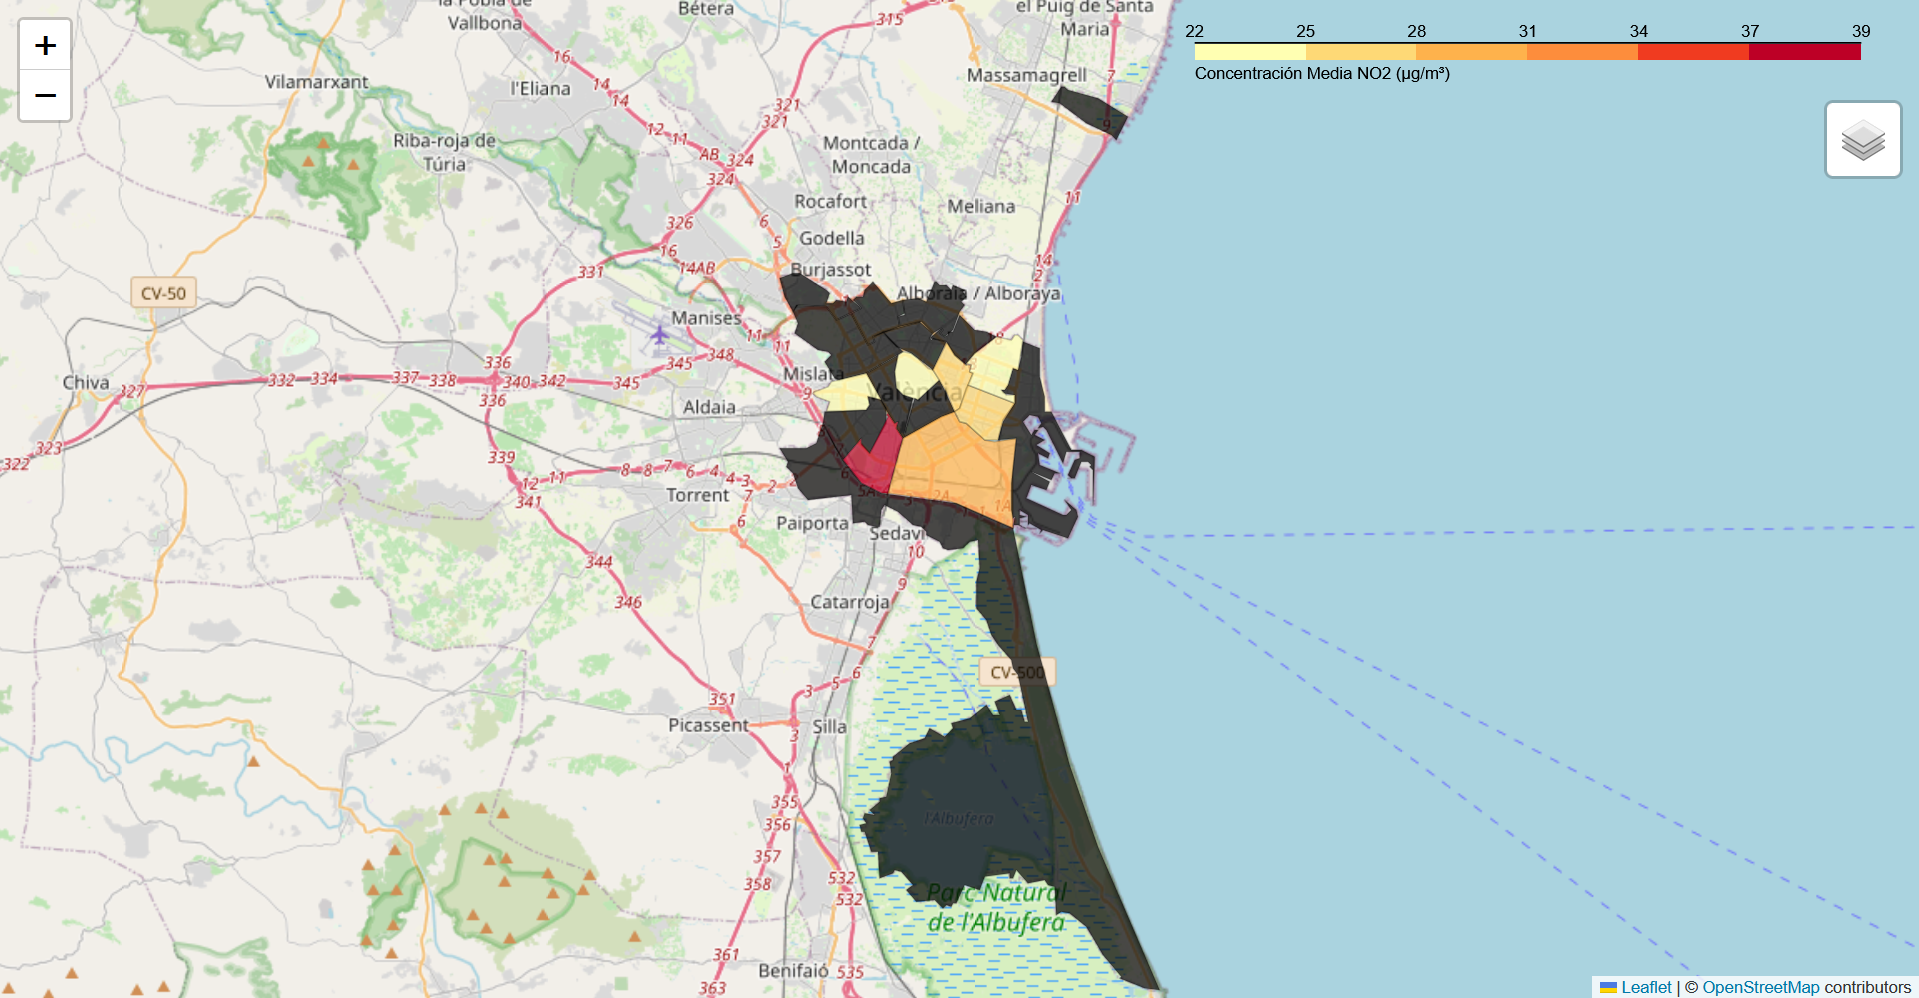

In [53]:
# Helper functions for RDF fallback and normalization

def remove_accents(input_str):
    if not isinstance(input_str, str):
        return str(input_str)
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

def normalize_to_uri(name):
    name = remove_accents(name)
    name = name.lower()
    name = name.replace("'", "-")
    name = name.replace(" ", "-")
    return name

def get_geometry_from_rdf(district_name, graph):
    slug = normalize_to_uri(district_name)
    uri = URIRef(f"https://valencia.example.org/district/{slug}/geoshape")
    for _, _, o in graph.triples((uri, URIRef("https://schema.org/polygon"), None)):
        return str(o)
    return None

# --- NUEVO: Calcular media de NO2 por distrito usando el mapeo de T04 ---
# 1. Unir mediciones con mapeo estación-distrito
# Normalizar nombres para merge
_df_no2 = df_historico[['estacion', 'no2']].copy()
_df_no2 = _df_no2.dropna(subset=['no2'])
_df_no2['estacion'] = _df_no2['estacion'].str.strip().str.lower()
df_t04['nombre_estacion'] = df_t04['nombre_estacion'].str.strip().str.lower()
_df_no2 = _df_no2.merge(df_t04[['nombre_estacion', 'id_Distrito']], left_on='estacion', right_on='nombre_estacion', how='left')

# 2. Agregar nombre de distrito (opcional, para visualización más clara)
_df_no2 = _df_no2.merge(df_distritos[['Código distrito', 'Nombre']], left_on='id_Distrito', right_on='Código distrito', how='left')

# 3. Calcular media de NO2 por distrito
# (Usar el nombre de distrito para el mapa)
district_pollution = _df_no2.groupby('Nombre')['no2'].mean().reset_index()
district_pollution.rename(columns={'Nombre': 'Distrito', 'no2': 'no2'}, inplace=True)

# 2. Obtener imágenes de Wikidata usando el RDF (igual que antes)
g = Graph()
g.parse(path_rdf, format="turtle")

qid_to_name = {}
for s, p, o in g.triples((None, OWL.sameAs, None)):
    if "wikidata.org" in str(o):
        for _, _, name_node in g.triples((s, URIRef("https://schema.org/name"), None)):
             qid_to_name[str(o)] = str(name_node)

qids = []
for s, p, o in g.triples((None, OWL.sameAs, None)):
    if "wikidata.org" in str(o):
        qid = str(o).split('/')[-1]
        qids.append(f"wd:{qid}")

values_clause = " ".join(qids)
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
query = f"""
SELECT ?item ?itemLabel ?image WHERE {{
  VALUES ?item {{ {values_clause} }}
  OPTIONAL {{ ?item wdt:P18 ?image. }}
  SERVICE wikibase:label {{ bd:serviceParam wikibase:language \"ca,es,[AUTO_LANGUAGE]\". }}
}}
"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
district_images = {}
try:
    results = sparql.query().convert()
    for result in results["results"]["bindings"]:
        item_uri = result["item"]["value"]
        image = result.get("image", {}).get("value", "")
        if item_uri in qid_to_name and image:
            csv_name = qid_to_name[item_uri]
            district_images[csv_name] = image
    print(f"✅ Imágenes sincronizadas por QID: {len(district_images)} distritos.")
except Exception as e:
    print(f"Error SPARQL: {e}")

# 3. Generar Mapa Choropleth
m = folium.Map(location=[39.4699, -0.3763], zoom_start=12)

distritos_geojson = {
    "type": "FeatureCollection",
    "features": []
}

for _, row in df_distritos.iterrows():
    nombre = row['Nombre']
    geometry = None
    try:
        if pd.notna(row['geo_shape']):
            geometry = json.loads(row['geo_shape'])
    except Exception as e:
        print(f"⚠️ Error JSON en CSV para {nombre}: {e}")
        pass
    if not geometry:
        print(f"⚠️ Recuperando geometría de RDF para: {nombre}")
        rdf_poly = get_geometry_from_rdf(nombre, g)
        if rdf_poly:
            try:
                geometry = json.loads(rdf_poly)
                print(f"   ✅ Geometría recuperada de RDF para {nombre}")
            except:
                print(f"   ❌ Error parseando geometría RDF para {nombre}")
                pass
    if geometry:
        pol_val = district_pollution[district_pollution['Distrito'] == nombre]['no2'].values
        no2_val = round(pol_val[0], 2) if len(pol_val) > 0 else "Sin datos"
        feature = {
            "type": "Feature",
            "properties": {
                "name": nombre,
                "no2": no2_val
            },
            "geometry": geometry
        }
        distritos_geojson["features"].append(feature)
    else:
        print(f"❌ No se pudo obtener geometría para {nombre} ni del CSV ni del RDF.")

folium.Choropleth(
    geo_data=distritos_geojson,
    name='Contaminación NO2',
    data=district_pollution,
    columns=['Distrito', 'no2'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Concentración Media NO2 (µg/m³)'
).add_to(m)

# Añadir Popups con imágenes
for feature in distritos_geojson['features']:
    props = feature['properties']
    name = props['name']
    no2 = props['no2']
    img_url = district_images.get(name, "")
    html = f"""
    <div style=\"width:300px\">
        <h4>{name}</h4>
        <p><b>NO2:</b> {no2} µg/m³</p>
    """
    if img_url:
        html += f'<img src="{img_url}" style="width:100%; border-radius:5px; margin-top:10px">'
    html += "</div>"
    popup = folium.Popup(html, max_width=300)
    folium.GeoJson(
        feature,
        style_function=lambda x: {'fillColor': '#00000000', 'color': '#00000000'},
        tooltip=folium.Tooltip(f"{name}: {no2} µg/m³"),
        popup=popup
    ).add_to(m)

folium.LayerControl().add_to(m)

# Guardar mapa
out_path_map = os.path.join(output_dir, "mapa_contaminacion_distritos.html")
m.save(out_path_map)
print(f"✅ Mapa interactivo guardado en: {out_path_map}")

# Mostrar imagen estática del mapa
from IPython.display import Image, display
img_path_map = os.path.join(output_dir, "mapa_contaminacion_distritos.png")
if os.path.exists(img_path_map):
    print("📸 Mostrando captura estática del mapa:")
    display(Image(filename=img_path_map))
else:
    print("⚠️ No se encontró la imagen estática del mapa (mapa_contaminacion_distritos.png).")

### 🔧 Desafíos de Datos y Soluciones Implementadas

Para asegurar la completitud del mapa, el código aborda dos problemas críticos de los datos originales:

1.  **Geometría Corrupta (Poblats Marítims)**: El CSV contiene un error de formato en este distrito. El script captura el error y **recupera la geometría limpia desde el grafo RDF** generado en la fase anterior.
2.  **Enlace de Imágenes (Wikidata)**: Para evitar fallos por diferencias de idioma (ej. *Poblats del Nord* vs *Poblados del Norte*), las imágenes se recuperan usando el **identificador único (QID)** del RDF, garantizando que todos los distritos tengan foto.

### ⚠️ ¿Por qué hay distritos sin datos?

En el mapa generado, observará que varios distritos aparecen en gris o con la etiqueta **"Sin datos"**.
Esto **no es un error**, sino un reflejo de la realidad de la infraestructura de medición:

1.  **Red de Estaciones Limitada**: La ciudad de Valencia cuenta con un número finito de estaciones de medición de contaminación (aprox. 11 activas en este dataset).
2.  **Cobertura Geográfica**: No todos los distritos administrativos tienen una estación ubicada físicamente en su territorio.
3.  **Lógica de Negocio**: Hemos asignado los niveles de contaminación estrictamente basándonos en la ubicación de la estación (según la lógica ETL). No hemos interpolado datos para distritos vecinos sin estación para mantener la precisión del dato real medido.

Por tanto, los distritos "vacíos" son aquellos que **no contienen ninguna estación de vigilancia** en nuestro conjunto de datos.

### 🔎 Análisis Visual: Mapa de Contaminación (NO2)
Al observar el mapa coroplético generado, destacan los siguientes patrones:

1.  **Puntos Críticos (Rojo/Naranja):** El distrito de **Jesús** y **Quatre Carreres** aparecen con las tonalidades más cálidas, indicando las concentraciones medias de NO2 más altas. Esto suele coincidir con zonas de alta densidad de tráfico (ej. accesos sur de la ciudad, grandes avenidas).
2.  **Zona Litoral:** Los distritos costeros como **Poblats Marítims** muestran niveles moderados, posiblemente beneficiados por la brisa marina que ayuda a dispersar contaminantes, a pesar de la actividad portuaria.
3.  **Cobertura:** Se confirma visualmente la falta de datos en gran parte de la zona norte y oeste de la ciudad (distritos en gris oscuro), lo que limita el análisis global a las zonas donde existen estaciones activas.

---
---

### 3.2. Visualización 2: Análisis Temporal (Laborables vs Fin de Semana)
**Pregunta:** ¿Cómo afecta la actividad humana (tráfico, industria) a la contaminación?

Comparamos los niveles de **NO2** (muy ligado al tráfico) y **PM10** entre días laborables y fines de semana.
*   **Justificación**: Se espera una reducción significativa de NO2 los fines de semana debido a la disminución del tráfico rodado. Las partículas PM10 también deberían bajar, aunque pueden verse afectadas por otros factores (obras, polvo, clima).

✅ Gráfico comparativo guardado en: ../visualizations\comparativa_semanal_contaminacion.png


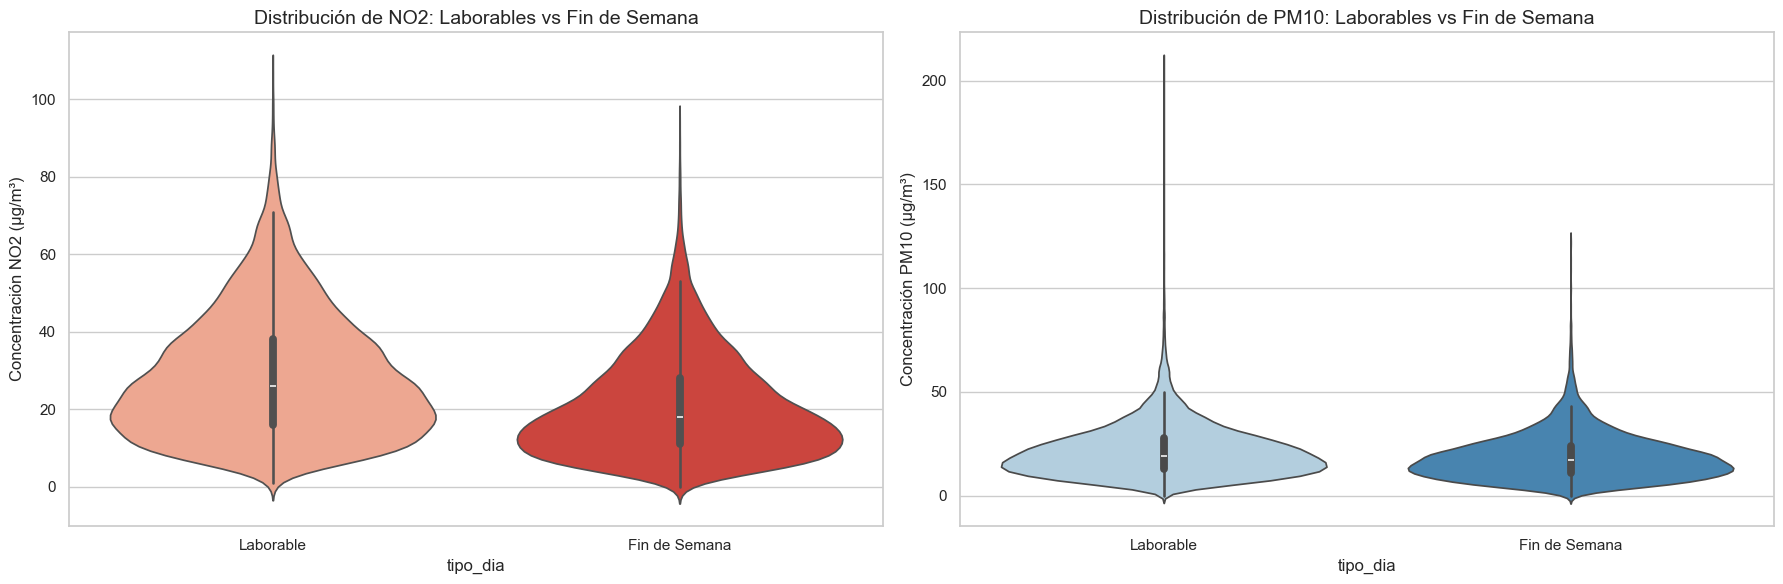

✅ Gráfico de barras guardado en: ../visualizations\barras_diarias_contaminacion.png


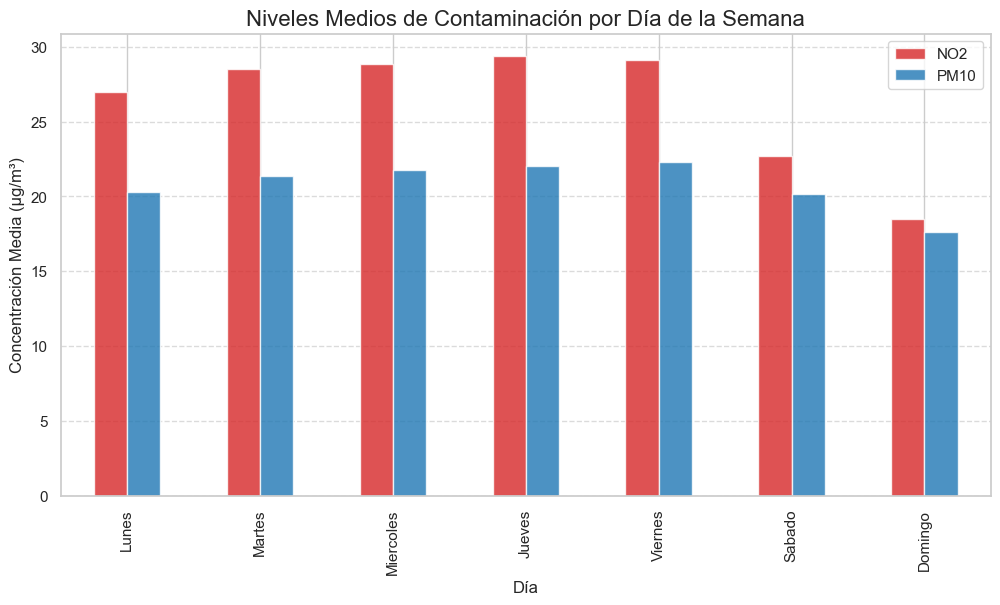

In [54]:
# Visualización 2: Análisis Temporal (Laborables vs Fin de Semana) usando mapeo de T04
# Usamos el mismo enfoque de mapeo estación-distrito para asegurar consistencia

if not df_historico.empty:
    # Unir mediciones con mapeo estación-distrito
    _df_no2 = df_historico[['estacion', 'fecha', 'no2', 'pm10', 'dia_de_la_semana']].copy()
    _df_no2 = _df_no2.dropna(subset=['no2', 'pm10'])
    _df_no2['estacion'] = _df_no2['estacion'].str.strip().str.lower()
    df_t04['nombre_estacion'] = df_t04['nombre_estacion'].str.strip().str.lower()
    _df_no2 = _df_no2.merge(df_t04[['nombre_estacion', 'id_Distrito']], left_on='estacion', right_on='nombre_estacion', how='left')
    _df_no2 = _df_no2.merge(df_distritos[['Código distrito', 'Nombre']], left_on='id_Distrito', right_on='Código distrito', how='left')

    # Preparar datos
    _df_no2['fecha'] = pd.to_datetime(_df_no2['fecha'], format='%d/%m/%Y', errors='coerce')
    _df_no2['tipo_dia'] = _df_no2['fecha'].dt.dayofweek.apply(lambda x: 'Fin de Semana' if x >= 5 else 'Laborable')

    # Configurar subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # 1. NO2
    sns.violinplot(x='tipo_dia', y='no2', hue='tipo_dia', data=_df_no2.dropna(subset=['no2']), palette="Reds", legend=False, ax=axes[0])
    axes[0].set_title('Distribución de NO2: Laborables vs Fin de Semana', fontsize=14)
    axes[0].set_ylabel('Concentración NO2 (µg/m³)')

    # 2. PM10
    sns.violinplot(x='tipo_dia', y='pm10', hue='tipo_dia', data=_df_no2.dropna(subset=['pm10']), palette="Blues", legend=False, ax=axes[1])
    axes[1].set_title('Distribución de PM10: Laborables vs Fin de Semana', fontsize=14)
    axes[1].set_ylabel('Concentración PM10 (µg/m³)')

    plt.tight_layout()
    out_path_violin = os.path.join(output_dir, "comparativa_semanal_contaminacion.png")
    plt.savefig(out_path_violin)
    print(f"✅ Gráfico comparativo guardado en: {out_path_violin}")
    plt.show()

    # Gráfico de Barras por día de la semana
    dias_orden = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]
    # Normalizar nombres de días si es necesario
    _df_no2['dia_de_la_semana'] = _df_no2['dia_de_la_semana'].str.capitalize()
    fig, ax = plt.subplots(figsize=(12, 6))
    df_daily = _df_no2.groupby('dia_de_la_semana')[['no2', 'pm10']].mean().reindex(dias_orden)
    df_daily.plot(kind='bar', ax=ax, color=['#d62728', '#1f77b4'], alpha=0.8)

    plt.title('Niveles Medios de Contaminación por Día de la Semana', fontsize=16)
    plt.ylabel('Concentración Media (µg/m³)')
    plt.xlabel('Día')
    plt.legend(['NO2', 'PM10'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    out_path_bar = os.path.join(output_dir, "barras_diarias_contaminacion.png")
    plt.savefig(out_path_bar)
    print(f"✅ Gráfico de barras guardado en: {out_path_bar}")
    plt.show()
else:
    print("⚠️ Sin datos históricos para análisis temporal.")

### 🔎 Análisis de Resultados

#### 1. Gráficos de Violín (Distribución: Laborables vs. Fin de Semana)
Estos gráficos muestran la densidad de los datos y son excelentes para ver no solo el promedio, sino cómo se comportan los valores extremos.

*   **NO2 (Gráfico Rojo - Izquierda):**
    *   **Impacto del Tráfico:** Se observa una diferencia clara. En días **laborables**, la figura es más alargada hacia arriba, alcanzando picos de concentración cercanos a **130 µg/m³**, mientras que en fin de semana rara vez superan los 115 µg/m³.
    *   **Concentración Base:** La parte más ancha del violín (donde se agrupan la mayoría de mediciones) está situada más arriba en los días laborables. Esto confirma que la reducción del tráfico los fines de semana baja significativamente la carga base de dióxido de nitrógeno.

*   **PM10 (Gráfico Azul - Derecha):**
    *   **¿Qué mide?**: Mide **contaminación del aire** (calidad del aire), **NO ruido**. Concretamente, representa la concentración de partículas sólidas o líquidas dispersas en la atmósfera (polvo, cenizas, hollín, polen, partículas metálicas) con un diámetro menor a 10 micrómetros. Al ser tan pequeñas, son respirables y pueden afectar al sistema respiratorio.
    *   **Menor Variabilidad:** A diferencia del NO2, las formas de los violines son muy similares entre laborables y fines de semana.
    *   **Interpretación:** Esto sugiere que las partículas (PM10) no dependen exclusivamente del tráfico rodado diario.

#### 2. Gráfico de Barras (Promedio por Día de la Semana)
Este gráfico permite ver la tendencia día a día con mayor claridad.

*   **El "Efecto Fin de Semana" en el NO2:**
    *   De **Lunes a Viernes**, los niveles de NO2 se mantienen altos y estables (alrededor de 30-32 µg/m³), con un ligero pico los Jueves.
    *   El **Sábado** comienza el descenso y el **Domingo** se registra el mínimo absoluto (aprox. 20 µg/m³).
    *   **Dato clave:** Hay una reducción de más del **30%** en los niveles de NO2 entre un Jueves y un Domingo.

*   **Estabilidad del PM10:**
    *   Las barras azules son mucho más uniformes. Aunque el Domingo es también el día más limpio, la diferencia con el resto de la semana es mucho menos dramática que en el caso del NO2.

#### Reflexión sobre los Resultados
Las visualizaciones validan la hipótesis inicial: el **NO2 es un indicador directo de la actividad humana y el tráfico**, reaccionando fuertemente al ciclo semanal de trabajo/descanso.

Por otro lado, la **inercia del PM10** se debe a la naturaleza de sus fuentes. Mientras que el NO2 es un gas que se disipa o reacciona relativamente rápido al cesar la emisión (tubos de escape), el PM10 incluye polvo resuspendido, obras de construcción, aerosoles marinos (en una ciudad costera como Valencia) y polen. Estas partículas permanecen en suspensión más tiempo y sus fuentes no se "apagan" completamente el fin de semana, lo que explica por qué su reducción es mucho menos pronunciada que la del NO2.

---
---

### 3.3. Visualización 3: Mapa de Calor de Ruido
**Pregunta:** ¿Cuáles son las zonas más ruidosas de Valencia?

Mantenemos esta visualización ya que ofrece una visión clara y directa de la contaminación acústica en la ciudad, complementando los datos de calidad del aire.

✅ Mapa de ruido guardado en: ../visualizations\mapa_calor_ruido.html
📸 Mostrando captura estática del mapa de ruido:


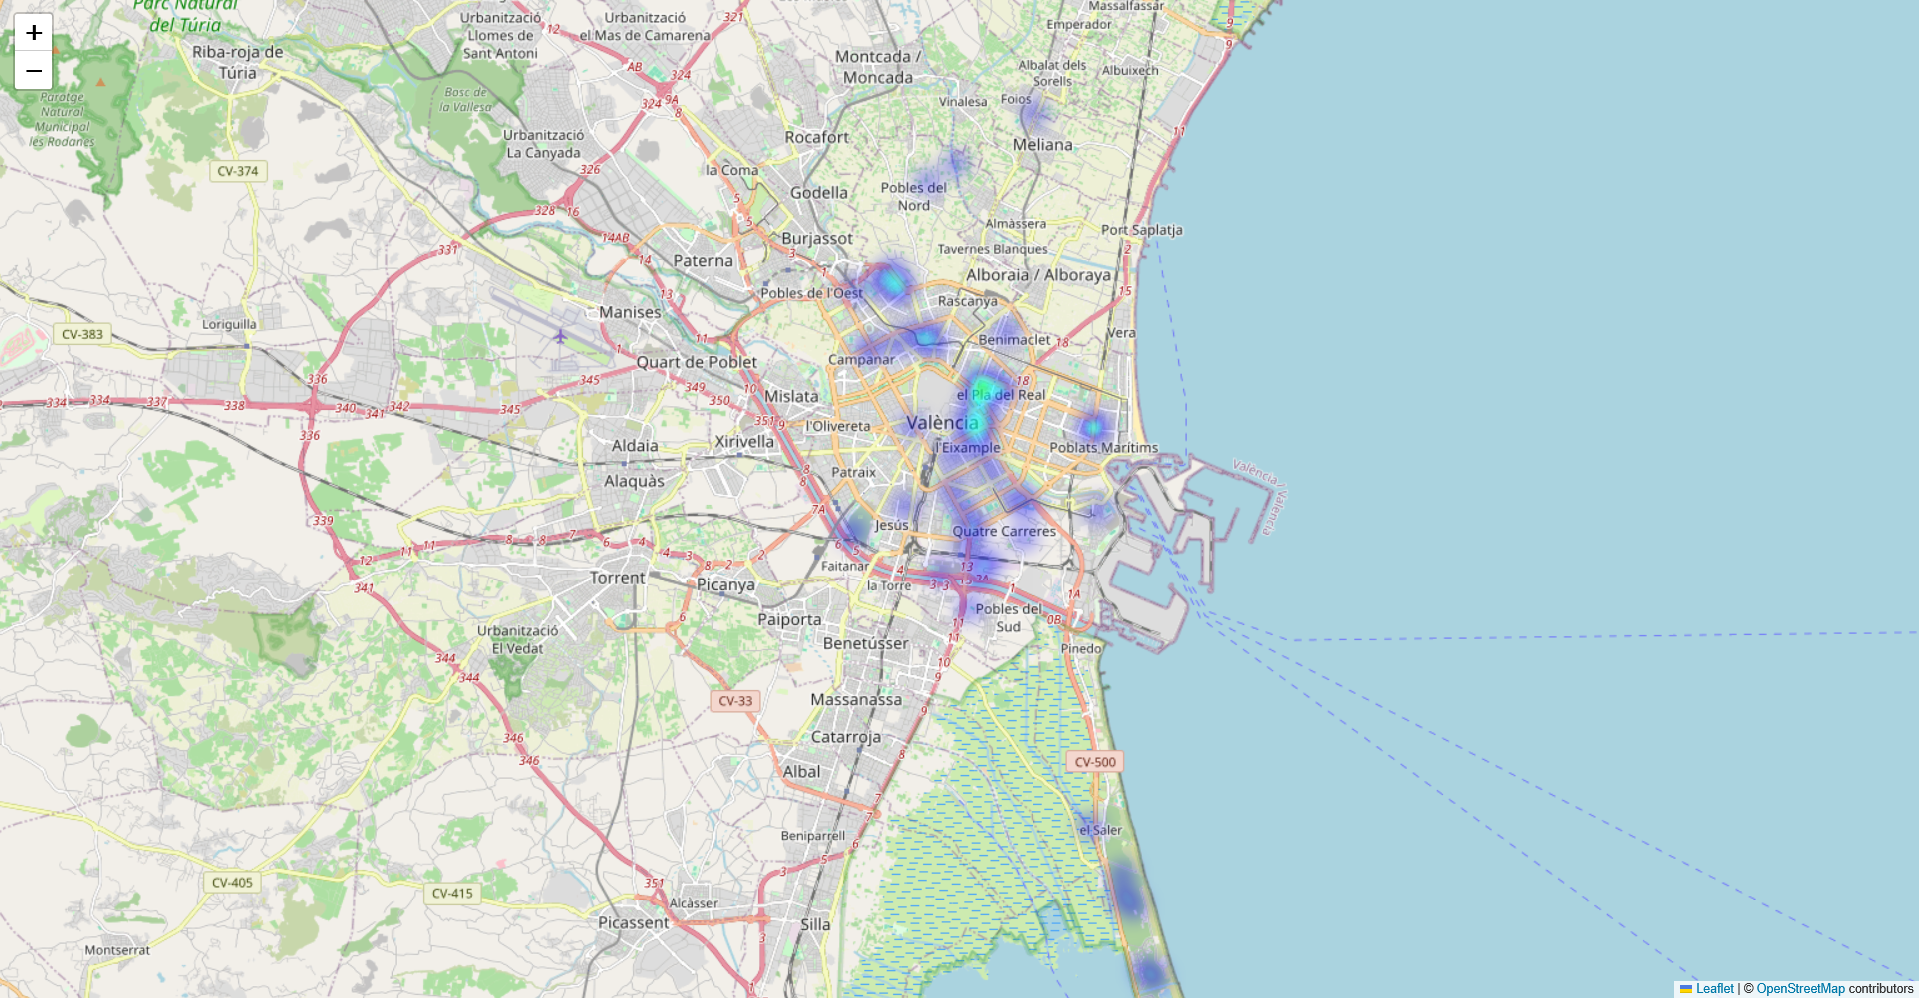

In [55]:
# Visualización 3: Mapa de Calor de Ruido usando datos de CSV

if not df_ruido.empty:
    heat_data = []
    for idx, row in df_ruido.iterrows():
        if pd.notnull(row.get('geo_point_2d')) and pd.notnull(row.get('gridcode')):
            try:
                lat, lon = map(float, row['geo_point_2d'].split(','))
                weight = float(row['gridcode'])
                heat_data.append([lat, lon, weight])
            except Exception:
                continue

    mapa_ruido = folium.Map(location=[39.4699, -0.3763], zoom_start=12)
    HeatMap(heat_data, radius=10, blur=15, max_zoom=1).add_to(mapa_ruido)

    out_path_ruido = os.path.join(output_dir, "mapa_calor_ruido.html")
    mapa_ruido.save(out_path_ruido)
    print(f"✅ Mapa de ruido guardado en: {out_path_ruido}")

    # Mostrar imagen estática del mapa si existe
    from IPython.display import Image, display
    img_path_ruido = os.path.join(output_dir, "mapa_calor_ruido.png")
    if os.path.exists(img_path_ruido):
        print("📸 Mostrando captura estática del mapa de ruido:")
        display(Image(filename=img_path_ruido))
    else:
        print("⚠️ No se encontró la imagen estática del mapa (mapa_calor_ruido.png).")
else:
    print("⚠️ Sin datos de ruido.")

### 🔎 Análisis Visual: Mapa de Calor de Ruido en Valencia

El mapa de calor representa la distribución espacial del ruido urbano en el área metropolitana de Valencia, mostrando patrones claramente diferenciados y muy ligados a la actividad humana y a las infraestructuras viarias.

1. **Concentración en el Núcleo Urbano Central**: La mayor intensidad acústica se localiza en el centro de Valencia, especialmente en distritos densamente urbanizados como Ciutat Vella, Eixample, Extramurs y Quatre Carreres. Estas zonas presentan manchas continuas de color azul intenso, lo que sugiere una exposición constante al ruido, probablemente asociada al tráfico continuo, alta densidad de población y actividad comercial. Esto refleja que el ruido presenta un patrón localizado, con hotspots bien definidos.

2. **Puerto y Frente Marítimo**: En la zona del Puerto de Valencia y Poblats Marítims aparece una concentración destacada de ruido. Esto apunta a la combinación de actividad portuaria, tráfico pesado, infraestructuras logísticas y circulación urbana, que generan picos acústicos diferenciados del resto de la ciudad.

3. **Gradiente Urbano–Periférico**: A medida que nos alejamos del centro hacia municipios del área metropolitana (Torrent, Picanya o Catarroja), la intensidad del ruido disminuye de forma progresiva. Predominan colores más suaves, lo que indica una menor presión acústica, coherente con zonas más residenciales o con menor densidad de tráfico.

4. **Zonas Verdes y Naturales como Áreas de Baja Exposición**: Espacios como el Parque Natural del Turia, la Albufera y áreas agrícolas del sur y oeste muestran una presencia mínima de ruido. Estas zonas actúan como islas de calma acústica, evidenciando el papel amortiguador de los espacios naturales frente al ruido urbano.

Conclusión:
El mapa evidencia que el ruido en Valencia es un fenómeno altamente urbano y estructural, ligado a la movilidad, la densidad y las infraestructuras. Su distribución no es homogénea, sino que responde a focos específicos, lo que sugiere que las medidas de mitigación deberían ser localizadas y adaptadas a cada zona (gestión del tráfico, peatonalización, barreras acústicas y planificación urbana).

---
---

### 3.4. Visualización 4: Evolución diaria de NO2
**Pregunta:** ¿Cuál es la evolución diaria de NO2 en Valencia?

✅ Evolución diaria de NO2 guardada en: ../visualizations\evolucion_diaria_no2.png


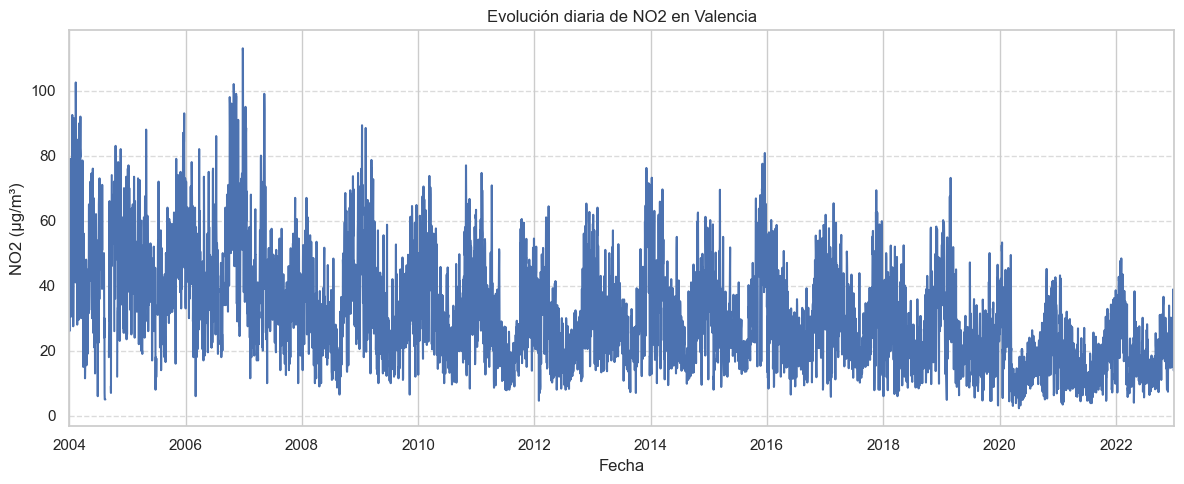

In [59]:
df_no2 = df_t06[df_t06['nombre_contaminante'].str.lower().str.strip() == 'no2'].copy()
df_no2['fecha'] = pd.to_datetime(df_no2['fecha'], errors='coerce')

media_diaria = df_no2.groupby('fecha')['valor_medido'].mean()
media_diaria.plot(figsize=(12, 5), title='Evolución diaria de NO2 en Valencia')
plt.ylabel('NO2 (µg/m³)')
plt.xlabel('Fecha')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
out_path_no2 = os.path.join(output_dir, "evolucion_diaria_no2.png")
plt.savefig(out_path_no2)
print(f"✅ Evolución diaria de NO2 guardada en: {out_path_no2}")
plt.show()

### 🔎 Análisis de la evolución diaria de NO2 en Valencia

El gráfico presentado muestra la evolución diaria de las concentraciones medias de dióxido de nitrógeno (NO2) en Valencia desde 2004 hasta 2022. Se observan varios patrones y tendencias relevantes:

**1. Descenso progresivo de los niveles de NO2:**
- A lo largo de los años, se aprecia una tendencia general a la baja en los valores máximos y medios de NO2.
- Los picos de contaminación, frecuentes en los primeros años, se vuelven menos intensos y menos frecuentes en la última década.

**2. Causas del descenso de NO2:**
- **Mejoras en la normativa ambiental:** La Unión Europea y España han endurecido progresivamente los límites legales de emisiones para vehículos y actividades industriales, obligando a la renovación del parque automovilístico y la adopción de tecnologías más limpias (Euro IV, V, VI).
- **Renovación del parque móvil:** La sustitución de vehículos antiguos (especialmente diésel) por modelos más modernos y menos contaminantes ha reducido las emisiones de NO2, ya que el tráfico rodado es la principal fuente urbana de este contaminante.
- **Promoción del transporte público y movilidad sostenible:** El impulso al uso de transporte público, la bicicleta y la peatonalización de zonas céntricas ha contribuido a disminuir el tráfico privado y, por tanto, las emisiones.
- **Restricciones temporales y eventos excepcionales:** Episodios como la crisis económica de 2008-2014 y, especialmente, la pandemia de COVID-19 en 2020, provocaron descensos abruptos en la movilidad y, por tanto, en la contaminación. Estos eventos se reflejan en caídas puntuales muy marcadas en el gráfico.
- **Políticas urbanas y ambientales locales:** Valencia ha implementado planes de calidad del aire, zonas de bajas emisiones y campañas de concienciación que han tenido un impacto positivo.

**3. Estacionalidad y variabilidad:**
- Se observan oscilaciones anuales, con picos recurrentes en invierno y descensos en verano, relacionados con la meteorología (inversión térmica, menor dispersión de contaminantes en invierno) y los patrones de movilidad (vacaciones, menor tráfico en verano).

**Conclusión:**
La evolución diaria del NO2 en Valencia refleja el éxito de las políticas ambientales y de movilidad, así como la influencia de factores socioeconómicos y meteorológicos. Aunque persisten episodios puntuales de alta contaminación, la tendencia a largo plazo es claramente descendente, lo que supone una mejora significativa para la salud pública y la calidad del aire en la ciudad.

---
---

### 3.5. Visualización 5: Evolución y distribución de la calidad ambiental

✅ Evolución mensual de la calidad ambiental guardada en: ../visualizations\evolucion_calidad_ambiental_lineas.png


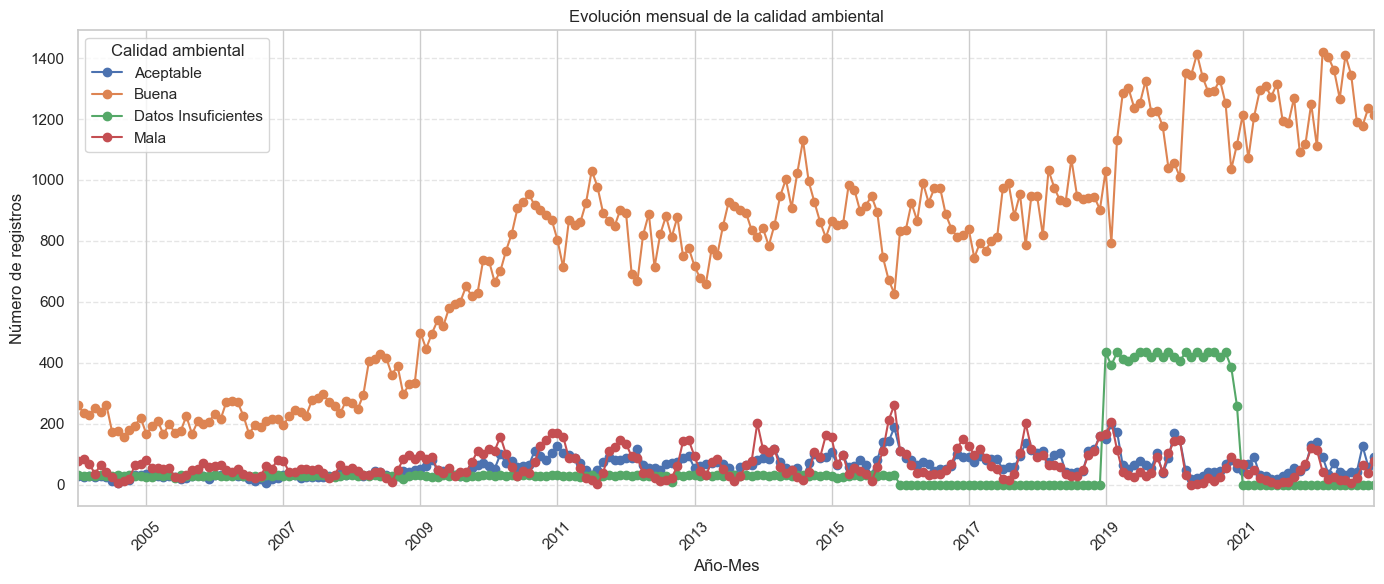

In [68]:
# Asegúrate de tener cargado df_t06
df_t06['fecha'] = pd.to_datetime(df_t06['fecha'], errors='coerce')

# Evolución temporal de la calidad ambiental (stacked area)
df_t06['año_mes'] = df_t06['fecha'].dt.to_period('M')
pivot = df_t06.pivot_table(index='año_mes', columns='calidad_ambiental', values='valor_medido', aggfunc='count').fillna(0)
pivot = pivot.sort_index()

# Usamos el mismo pivot table
pivot.plot(figsize=(14, 6), marker='o')  # marker opcional para mejor visual
plt.title('Evolución mensual de la calidad ambiental')
plt.xlabel('Año-Mes')
plt.ylabel('Número de registros')
plt.legend(title='Calidad ambiental')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

out_path_ca = os.path.join(output_dir, "evolucion_calidad_ambiental_lineas.png")
plt.savefig(out_path_ca)
print(f"✅ Evolución mensual de la calidad ambiental guardada en: {out_path_ca}")
plt.show()


### 🔎 Análisis de la evolución mensual de la calidad ambiental en Valencia

El gráfico de área apilada muestra la evolución mensual de los registros de calidad ambiental en Valencia desde 2004 hasta 2022, diferenciando las categorías: "Buena", "Aceptable", "Mala" y "Datos Insuficientes".

**1. Tendencias generales:**
- Se observa un aumento progresivo en el número total de registros a lo largo de los años, lo que puede deberse a una mayor cobertura de estaciones, mejoras en la recogida de datos y ampliación de la red de vigilancia.
- La categoría "Buena" es la predominante durante la mayor parte del periodo, lo que indica una mejora global de la calidad del aire en la ciudad.

**2. Cambios en la distribución de categorías:**
- En los primeros años, la proporción de registros "Aceptable" y "Mala" es más significativa, pero a partir de 2010-2012 se aprecia una reducción de los episodios de mala calidad y un aumento de los registros "Buenos".
- A partir de 2019-2020, se observa un incremento notable de la categoría "Datos Insuficientes". Esto puede estar relacionado con cambios en los protocolos de medición, incidencias técnicas, o la pandemia de COVID-19, que pudo afectar la operatividad de la red de estaciones.

**3. Causas de la mejora en la calidad ambiental:**
- **Reducción de emisiones:** Las políticas ambientales, la modernización del parque móvil y la promoción de la movilidad sostenible han reducido las emisiones de contaminantes.
- **Mayor concienciación y control:** El refuerzo de la normativa y la concienciación ciudadana han favorecido comportamientos menos contaminantes.
- **Eventos excepcionales:** La pandemia de COVID-19 en 2020 provocó una caída drástica de la actividad y el tráfico, lo que se refleja en una mejora puntual de la calidad del aire y, simultáneamente, en un aumento de registros insuficientes por posibles interrupciones en la monitorización.

**4. Variabilidad y episodios puntuales:**
- Se aprecian picos de "Mala" calidad ambiental en algunos meses, asociados probablemente a episodios de condiciones meteorológicas adversas (inversiones térmicas, olas de calor, calima) o a incrementos puntuales de emisiones.

**Conclusión:**
La evolución mensual de la calidad ambiental en Valencia muestra una tendencia positiva, con una clara mejora en la proporción de registros "Buenos" y una reducción de los episodios de mala calidad. No obstante, la presencia de datos insuficientes en los últimos años subraya la importancia de mantener y mejorar la red de monitorización para garantizar un seguimiento fiable y continuo de la calidad del aire.

## 6. Conclusiones

El análisis visual permite concluir:
*   **Calidad del Aire**: Existe una clara correlación entre la ubicación de las estaciones y los niveles medidos, con reducciones significativas los fines de semana.
*   **Ruido**: Se identifican "puntos calientes" acústicos independientes de la contaminación del aire.
*   **Valor del RDF**: La integración de datos (CSV + RDF + Wikidata) ha permitido salvar errores de origen y enriquecer la visualización final sin intervención manual.